# Projeto Final da Disciplina Mineração de Textos e Web Ministrada pelo Prof. Luciano Barbosa

**Equipe:**
<br>David Soares do Monte
<br>Wanderson Rodrigues Marques


# Etapa 1: Dataset

## Informações sobre o dataset
O dataset é composto por 5000 avaliações obtidas no site da Amazon Brasil referentes ao produto "Suporte para Notebook, OCTOO, Uptable, UP-BL, Preto" (https://www.amazon.com.br/OCTOO-UP-BL-Suporte-Uptable-Preto/dp/B07BTC67VS/ref=zg-bs_furniture_1/144-8354270-3806822).

## Importação das Bibliotecas Necessárias

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sn
import math
import os
import pickle
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn import metrics
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data.dataset import Dataset
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook

## Instalação de bibliotecas

In [ ]:
!pip install transformers
from transformers import AdamW, BertForSequenceClassification, BertTokenizer, DataCollatorWithPadding

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importação e Pré-processamento do Dataset

In [ ]:
# Função para o 'date_parser' para converter a data no momento de leitura do dataset através do 'pd.read_csv'

def date_converter(date):
    month = 0
    month_list = ['janeiro', 'fevereiro', 'março', 'abril', 'maio', 'junho', 'julho', 
                  'agosto', 'setembro', 'outubro', 'novembro', 'dezembro']
    
    date_sep = date.split(' ') # Ex.: '24 de setembro de 2019' => ['24', 'de', 'setembro', 'de', '2019']
    
    for i, m in enumerate(month_list): # Verifica a terceira posição da lista para fazer a conversão do mês
        if date_sep[2] == m:
            month = i + 1
            break
    
    year = int(date_sep[4]) # Última posição da lista 'date_sep'
    day = int(date_sep[0])  # Primeira posição da lista 'date_sep'
            
    date_conv = dt.date(year=year, month=month, day=day) # Compõe a data que será retornada
    
    return date_conv

In [ ]:
# Importa o dataset

df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP Projeto Final/av_positivo_projeto_NLP_4560.csv', decimal=',', parse_dates=[2], 
                 date_parser=date_converter, usecols=['reviews', 'star', 'date'])
df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP Projeto Final/av_critico_projeto_NLP_1330.csv', decimal=',', parse_dates=[2], 
                 date_parser=date_converter, usecols=['reviews', 'star', 'date'])
df = pd.concat([df1, df2])
df.reset_index(drop=True, inplace=True)

In [ ]:
# Imprime 5 amostras do dataset

df.sample(5)

,reviews,star,date
3955,Recomendo o produto !,4.0,2020-10-20
4801,"O PRODUTO NÃO PRESTA! TORTO, NÃO TEM ERGONOMIA...",1.0,2021-12-29
4288,Ótimo produto! Pra quem usa notebook no dia a ...,5.0,2020-12-12
144,Pelo preço é um excelente investimento. Já uti...,5.0,2020-07-15
4575,Ele não possuí uma regulação de angulo satisfa...,1.0,2020-08-14


In [ ]:
# Imprime formato do dataset

print('Shape do dataset:', df.shape)

Shape do dataset: (5890, 3)


*   Deste ponto em diante será utilizado o dataset 'df_reviews'



In [ ]:
# Ordena o dataset pela data, cria uma cópia (df_reviews) e faz o reset dos índices

df_reviews = df.sort_values(by=['date']).copy()
df_reviews.reset_index(drop=True, inplace=True)

# Adiciona a coluna 'sentiment' baseado no critério: positivo se star > 3 e negativo caso contrário

df_reviews['sentiment'] = df_reviews['star'].apply(lambda v: 'positive' if v > 3 else 'negative')

# Reordena as colunas do dataset

df_reviews = df_reviews[['date', 'reviews', 'star', 'sentiment']]

# Redefine os tipos dos dados

df_reviews['reviews'] = df_reviews['reviews'].astype('category')
df_reviews['star'] = df_reviews['star'].astype('int8')
df_reviews['star'] = df_reviews['star'].astype('category')
df_reviews['sentiment'] = df_reviews['sentiment'].astype('category')

In [ ]:
df_reviews.head()

,date,reviews,star,sentiment
0,2019-04-07,"Leve, simples, ocupa pouco espaço.",5,positive
1,2019-09-24,"Produto de boa qualidade, tanto pela aparência...",4,positive
2,2019-10-10,"Duro, pequeno e não tão resistente. Já desinca...",2,negative
3,2019-10-31,"Fácil de montar e desmontar, pode ser posicion...",5,positive
4,2019-12-02,"Prático, leve e resistente",5,positive


In [ ]:
# Intervalo de datas no qual foram capturadas os reviews

print('Período das reviews: ', df_reviews['date'].min().strftime('%Y-%m-%d'), 'a',\
      df_reviews['date'].max().strftime('%Y-%m-%d'))

Período das reviews:  2019-04-07 a 2022-03-22


In [ ]:
# Verificação de dados ausentes

(df_reviews.isna().sum())

date          0
reviews      59
star          0
sentiment     0
dtype: int64

In [ ]:
# Remove instâncias com reviews vazias

df_reviews.dropna(axis=0, how='any', inplace=True, subset=['reviews'])
df_reviews.reset_index(drop=True, inplace=True)
df_reviews.shape

(5831, 4)

In [ ]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5831 entries, 0 to 5830
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       5831 non-null   datetime64[ns]
 1   reviews    5831 non-null   category      
 2   star       5831 non-null   category      
 3   sentiment  5831 non-null   category      
dtypes: category(3), datetime64[ns](1)
memory usage: 240.1 KB


In [ ]:
# Descrição das variáveis categóricas

df_reviews.describe(include='category')

,reviews,star,sentiment
count,5831,5831,5831
unique,5413,5,2
top,Muito bom,5,positive
freq,64,3552,4520


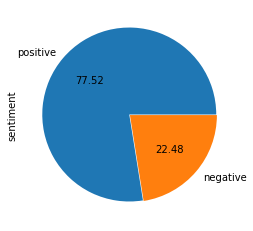

In [ ]:
# Verificação do balaceamento das classes - coluna 'sentiment'
df_reviews['sentiment'].value_counts().plot.pie(autopct='%.2f', explode=[0.01, 0]);

Os dados estão desbalanceados

# Etapa 2: Processamento dos Dados Textuais

## Fazendo Split nos dados

In [ ]:
seed = 1275

train_dev, test = train_test_split(df_reviews, test_size=0.1, random_state=seed, stratify=df_reviews['sentiment'])
train, dev = train_test_split(train_dev, test_size=0.2, random_state=seed, stratify=train_dev['sentiment'])

print('Tamanho de treino:', train.shape[0])
print('Tamanho de validação:', dev.shape[0])
print('Tamanho de teste:', test.shape[0])

Tamanho de treino: 4197
Tamanho de validação: 1050
Tamanho de teste: 584


Convertendo a classe para numérico

In [ ]:
y_test = test['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

## C4: BERT
Classe criada para tokenizar os exemplos e fornecer os pares de inputs e labels para o modelo

In [ ]:
class defClass(Dataset):  
    def __init__(self, tokenizer, X, y):
        X = list(X)
        y = list(y)
        tokenized_data = tokenizer(X, truncation=True, max_length=512)
        samples = [
            {
                **{key: tokenized_data[key][i] for key in tokenized_data},
                'labels': y[i]
            }
             
            for i in range(len(X))
        ]
        self.samples = samples
    
    def __getitem__(self, i):
        return self.samples[i]
    
    def __len__(self):
        return len(self.samples)

### Função auxiliar

Enviando as entradas para o device

In [ ]:
def send_inputs_to_device(inputs, device):
    return {key:tensor.to(device) for key, tensor in inputs.items()}

## Preparando os dados (Tokenização)

Treino, validação e teste

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
train_dataset = defClass(tokenizer, train['reviews'], (train['sentiment'] == 'positive').astype(int))
dev_dataset   = defClass(tokenizer, dev['reviews'], (dev['sentiment'] == 'positive').astype(int))
test_dataset  = defClass(tokenizer, test['reviews'], (test['sentiment'] == 'positive').astype(int))

In [ ]:
len(tokenizer.vocab)

29794

Aqui, nós vamos utilizar o DataCollatorWithPadding. Uma vez que os nossos exemplos podem ter comprimentos diferentes, precisamos colocar padding para juntá-los em um batch. O DataCollatorWithPadding já faz isso para nós.

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, collate_fn=DataCollatorWithPadding(tokenizer))
dev_loader = DataLoader(dev_dataset, batch_size=16, collate_fn=DataCollatorWithPadding(tokenizer))
test_loader = DataLoader(test_dataset, batch_size=16, collate_fn=DataCollatorWithPadding(tokenizer))

### Implementação o modelo e otimizador - PT-BR
Aqui nós definimos uma coisa extra que é começar o modelo com a parte pré treinada do BERT congelada. Assim a gente permite aos pesos do layer de classificação se acomodarem antes de começar a fazer o fine-tune na rede toda.

In [ ]:
from transformers import logging
logging.set_verbosity_error()
model = BertForSequenceClassification.from_pretrained(
    'neuralmind/bert-base-portuguese-cased')
model.train()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-6) # Alterei o otimizador
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9997)


for param in model.base_model.parameters():
    param.requires_grad = False

## Treinando o modelo
Aqui vamos fazer a avaliação no devset a cada 200 passos. No passo 800 vamos soltar os pesos do modelo base do BERT pra aprender.

In [ ]:
def evaluate(model, dev_loader, device):
    with torch.no_grad():
        model.eval()
        dev_losses = []
        tp, tn, fp, fn = [], [], [], []
        for inputs in dev_loader:
            inputs = send_inputs_to_device(inputs, device)
            loss, scores = model(**inputs)[:2]
            dev_losses.append(loss.cpu().item())

            _, classification = torch.max(scores, 1)
            labels = inputs['labels']
            tp.append(((classification==1) & (labels==1)).sum().cpu().item())
            tn.append(((classification==0) & (labels==0)).sum().cpu().item())
            fp.append(((classification==1) & (labels==0)).sum().cpu().item())
            fn.append(((classification==0) & (labels==1)).sum().cpu().item())

        tp_s, tn_s, fp_s, fn_s = sum(tp), sum(tn), sum(fp), sum(fn)
        print('Dev loss: {:.2f}; Acc: {:.2f}; tp: {}; tn: {}; fp: {}; fn: {}'.format( 
              np.mean(dev_losses), (tp_s+tn_s)/(tp_s+tn_s+fp_s+fn_s), tp_s, tn_s, fp_s, fn_s))

        model.train()

In [ ]:
epoch_bar = tqdm_notebook(range(3))
loss_acc = 0
alpha = 0.95
for epoch in epoch_bar:
    batch_bar = tqdm_notebook(enumerate(train_loader), desc=f'Época {epoch}', total=len(train_loader))
    for idx, inputs in batch_bar:
        if (epoch * len(train_loader) + idx) == 800:
            for param in model.base_model.parameters():
                param.requires_grad = True

        inputs = send_inputs_to_device(inputs, device)
        optimizer.zero_grad()
        loss, logits = model(**inputs)[:2]
        
        loss.backward()
        optimizer.step()
        if epoch == 0 and idx == 0:
            loss_acc = loss.cpu().item()
        else:
            loss_acc = loss_acc * alpha + (1-alpha) * loss.cpu().item()
        batch_bar.set_postfix(loss=loss_acc)
        if idx%200 == 0:
            del inputs
            del loss
            evaluate(model, dev_loader, device)

        scheduler.step()
     

  0%|          | 0/3 [00:00<?, ?it/s]

Época 0:   0%|          | 0/525 [00:00<?, ?it/s]

Dev loss: 0.84; Acc: 0.23; tp: 15; tn: 224; fp: 12; fn: 799
Dev loss: 0.77; Acc: 0.23; tp: 19; tn: 221; fp: 15; fn: 795
Dev loss: 0.71; Acc: 0.31; tp: 139; tn: 186; fp: 50; fn: 675


Época 1:   0%|          | 0/525 [00:00<?, ?it/s]

Dev loss: 0.69; Acc: 0.58; tp: 543; tn: 71; fp: 165; fn: 271
Dev loss: 0.65; Acc: 0.76; tp: 789; tn: 9; fp: 227; fn: 25
Dev loss: 0.39; Acc: 0.80; tp: 810; tn: 31; fp: 205; fn: 4


Época 2:   0%|          | 0/525 [00:00<?, ?it/s]

Dev loss: 0.24; Acc: 0.91; tp: 754; tn: 197; fp: 39; fn: 60
Dev loss: 0.21; Acc: 0.92; tp: 780; tn: 190; fp: 46; fn: 34
Dev loss: 0.21; Acc: 0.92; tp: 786; tn: 181; fp: 55; fn: 28


### Validando o modelo
Agora vamos verificar o desempenho no dev set. Vamos ver a curva ROC e tb qual o melhor threshold de classificação com respeito a nossa métrica escolhida, acurácia

In [ ]:
with torch.no_grad():
    model.eval()
    pred = []
    labels = []
    for inputs in tqdm_notebook(dev_loader):
        inputs = send_inputs_to_device(inputs, device)
        _, scores = model(**inputs)[:2]
        pred.append(F.softmax(scores, dim=1)[:, 1].cpu())
        labels.append(inputs['labels'].cpu())
pred = torch.cat(pred).numpy()
labels = torch.cat(labels).numpy()

  0%|          | 0/66 [00:00<?, ?it/s]

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(labels, pred, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

fig = px.scatter(
    x=fpr, y=tpr, color=thresholds, 
    labels={'x': 'Falso positivo rate', 'y': 'Verdadeiro positivo rate'},
    title='Curva ROC')
fig.show()

In [ ]:
acc = []
for th in thresholds:
    acc.append(metrics.accuracy_score(pred > th, labels))

fig2 = px.scatter(
    x=thresholds, y=acc, labels={'x': 'threshold', 'y': 'acurácia'}, 
    title='Acurácia em diferentes thresholds')
fig2.show() 

## Avaliação final
Finalmente vamos avaliar o modelo no conjunto de test com o threshold escolhido

In [ ]:
with torch.no_grad():
    model.eval()
    pred = []
    labels = []
    for inputs in tqdm_notebook(test_loader):
        inputs = send_inputs_to_device(inputs, device)
        _, scores = model(**inputs)[:2]
        pred.append(F.softmax(scores, dim=1)[:, 1].cpu())
        labels.append(inputs['labels'].cpu())
pred = torch.cat(pred).numpy()
labels = torch.cat(labels).numpy()

  0%|          | 0/37 [00:00<?, ?it/s]

In [ ]:
y_pred = [1 if x > 0.5 else 0 for x in pred]

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("\nClasification report:\n", classification_report(y_test, y_pred))


Clasification report:
               precision    recall  f1-score   support

           0       0.85      0.82      0.84       131
           1       0.95      0.96      0.95       453

    accuracy                           0.93       584
   macro avg       0.90      0.89      0.90       584
weighted avg       0.93      0.93      0.93       584

Confusion matrix:
 [[108  23]
 [ 19 434]]


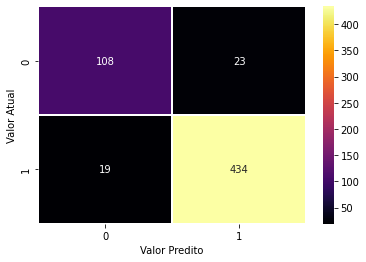

In [ ]:
# Matriz de confusão com heatmap
cnn_confusion_matrix = pd.crosstab(np.reshape(y_test, len(y_pred)), np.reshape(y_pred, len(y_pred)), rownames=['Valor Atual'], colnames=['Valor Predito'])

sn.heatmap(cnn_confusion_matrix, annot=True, fmt="d", cmap='inferno', linewidths=.5)
plt.show()